In [1]:
import numpy 
import scipy
from scipy.signal import find_peaks
import itertools, sys, os, copy, pickle
sys.path.append('/mnt/home/szheng/projects/util_code')



import data_prep_new as dpn
import place_cell_analysis as pa
import plot_helper as ph
import plot_raster as pr
from importlib import reload
import matplotlib.pyplot as plt
import pandas as pd
# from tqdm import tqdm
from tqdm.notebook import tqdm
import jax
import jax.numpy as np
import jax.scipy as scipy
from jax import value_and_grad, grad, jit, vmap, jacfwd, jacrev
from jax.example_libraries import optimizers as jax_opt

import gm
import gm_plot as gp
import gm_plot_diagnostic as gpd
import seaborn as sns
%matplotlib inline

In [2]:
sess_name="e15_13f1_220117"
py_data_dir = "/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220117/py_data"
fr_map_ = pickle.load(open(os.path.join(py_data_dir,'fr_map.p'),'rb'))

# %%
fr_map=fr_map_['fr_map']
fr_map_trial=fr_map_['fr_map_trial']

args=pr.preprocess_for_plot(sess_name,sigma=30,speedmask=5,n_pos_bins=100)
section_colordict,spk_triggered_positions_trial_all_speedmasked,pos_bins_dict,choice = args[4:8]
bin_to_lin=copy.copy(pos_bins_dict['lin'])
bin_to_lin=np.concatenate([bin_to_lin[:-1,None],bin_to_lin[1:,None]],axis=1).mean(axis=1)

ind = 0
uid_l = fr_map[0].index
uid = uid_l[ind] # 1 indexed
uid_num = int(uid.split('_')[1])-1 # 0 indexed

ch=0
trial_mask = choice==ch

spk_triggered_positions_trial_one_unit = spk_triggered_positions_trial_all_speedmasked[uid_num]
spk_triggered_positions_trial  = spk_triggered_positions_trial_one_unit[trial_mask]


2022-06-14 14:58:01.010927: E external/org_tensorflow/tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [3]:
# load cv result
fn='/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220117/py_data/gm_fit/test_cv/ind_0_ch_0_sweep.p'
# reg_pars_and_loss_df.to_pickle(fn)
reg_pars_and_loss_df = pd.read_pickle(fn)
reg_pars_and_loss_df_mean = reg_pars_and_loss_df.groupby(['g_w','g_sigma','g_mu','nfields']).mean()


In [27]:
reg_pars_and_loss_df_mean.loc[100,1,0.1]

,test_loss,train_loss
nfields,,
2,5.817672,5.856342
3,6.510179,4.618090
4,4.373140,2.939638


In [34]:
reg_pars_and_loss_df_mean.loc[10000,1,1,4]

test_loss     3.260070
train_loss    1.346327
Name: (10000, 1, 1.0, 4), dtype: float32

In [26]:
reg_pars_and_loss_df_mean.loc[10000,1000000,1,4]

test_loss     6.865567
train_loss    1.069212
Name: (10000, 1000000, 1.0, 4), dtype: float32

In [6]:
# fit good and bad trials
reload(gpd)
ys_l = fr_map_trial[0][0]
reg_pars_good = {'g_sigma':1.,'g_mu':1.,'g_w':10000,'nfields':4}
# reg_pars_bad = {'g_sigma':1000000.,'g_mu':10000.,'g_w':100.,'nfields':3}
reg_pars_bad = {'g_sigma':1000000.,'g_mu':1.,'g_w':10000.,'nfields':4}
# reg_pars_dict = {'good':reg_pars_good,'bad':reg_pars_bad}

pars_learned_dict, test_loss_dict,mask= gpd.fit_good_bad_trials(ys_l,reg_pars_good,reg_pars_bad,mask_ratio=0.2,regressors_={},reg_type='quad_variation',loss_type='mse',niters=4000)



In [10]:
test_loss_dict

{'good': DeviceArray(3.3599145, dtype=float32),
 'bad': DeviceArray(8.244699, dtype=float32)}

In [11]:
reload(gpd)
# get the yhat for different fit
ys_hat_dict=gpd.get_yhat_multi_fit(pars_learned_dict,regressors_={})

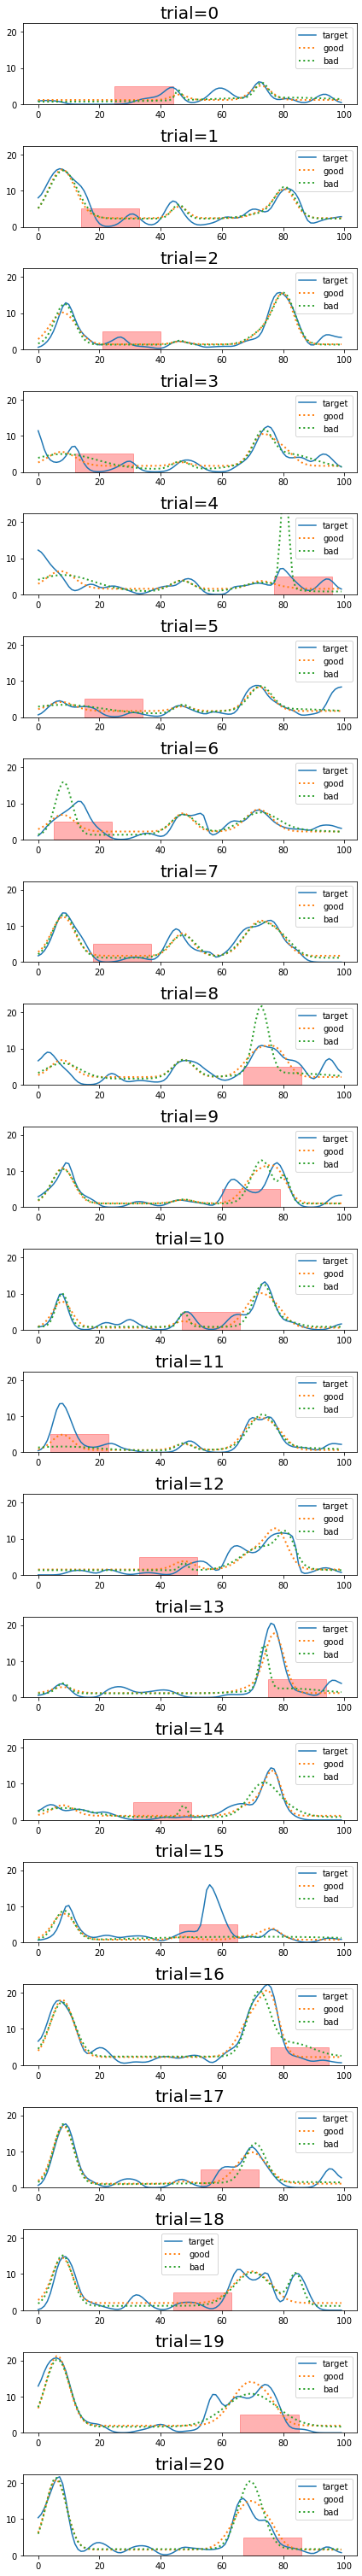

In [12]:
# trial by trial comparison between good and bad hyperparam fit
reload(gpd)
    
fig,ax=gpd.trial_by_trial_good_bad_comparison(ys_l,ys_hat_dict,tr_l=None,fig=None,ax=None,mask=mask)


In [23]:
for key in ['sigmas','ws','mus']:
    print(key,'\n',pars_learned_dict['bad'][key][7:10])

sigmas 
 [[ 3.7551649  4.2150946  5.4517374  3.938469 ]
 [ 5.7205133  3.614739   2.4768949 15.595914 ]
 [ 3.7149007  2.964165   3.4587035  1.649182 ]]
ws 
 [[112.20073   66.32782  129.70747   27.26994 ]
 [ 61.384502  45.963036 116.507484  60.82681 ]
 [ 89.317215   8.42423  103.58408   28.088497]]
mus 
 [[ 8.416205 47.253334 72.50632  80.51664 ]
 [ 8.006249 47.50454  72.75915  80.581184]
 [ 8.100138 47.524216 73.01244  80.616974]]


In [24]:
for key in ['sigmas','ws','mus']:
    print(key,'\n',pars_learned_dict['good'][key][7:10])

sigmas 
 [[3.759674  3.3743932 4.4506836 3.2970207]
 [3.717269  3.3435876 4.308053  3.2876663]
 [3.492635  3.2958932 4.28776   3.2630036]]
ws 
 [[101.68223    52.600845  101.271515   33.783104 ]
 [ 43.90694    40.410694   78.60691    44.78914  ]
 [ 85.60274     7.9268603  90.37357    55.06211  ]]
mus 
 [[ 8.149323 47.1792   71.884224 78.747116]
 [ 7.755375 47.46554  71.96071  78.55226 ]
 [ 8.008994 47.51273  71.92839  78.34964 ]]


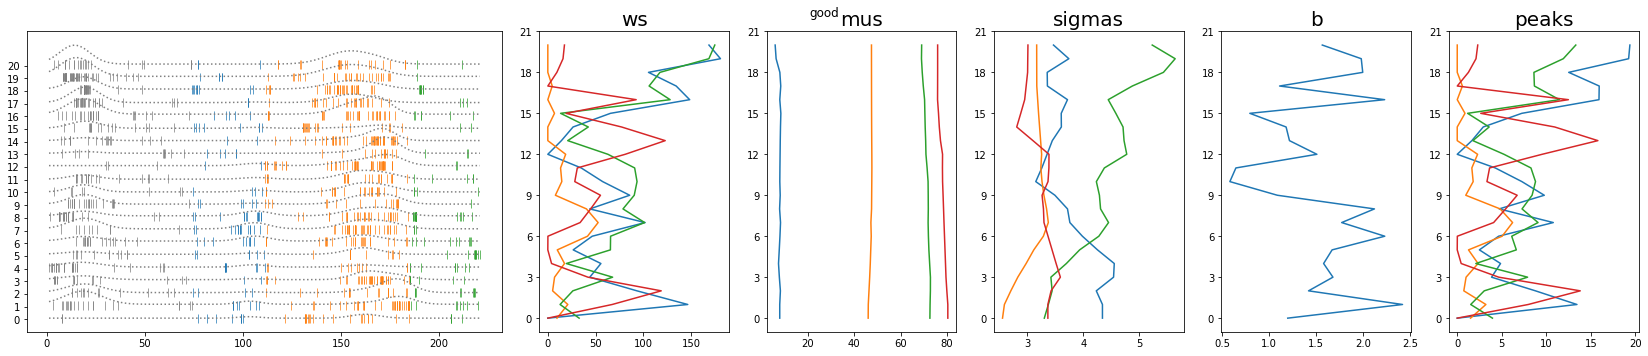

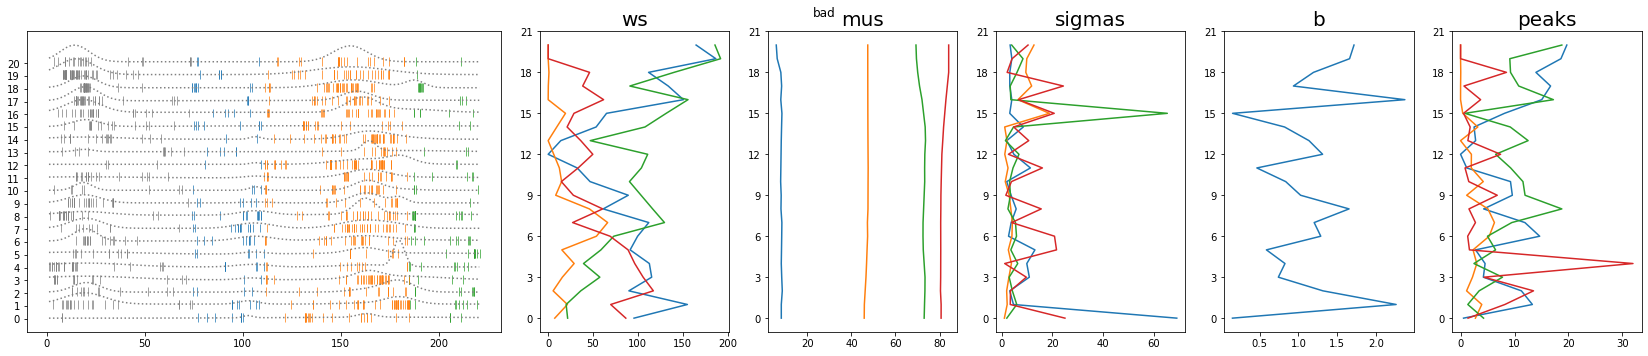

In [14]:
# fitted params for good and bad hyperparam
for key,val in pars_learned_dict.items():
    pars_learned = val
    fig,ax=gp.plot_fit_original_raster_param_1trial(fr_map_trial,ind,choice,spk_triggered_positions_trial,fig=None,axs=None,pars_learned=pars_learned,ch=0,gm_fit_dir=None,nooriginal=True,figsize=(23,5),bin_to_lin=bin_to_lin,nparams=5,displacement=None)
    fig.suptitle(key)
    


In [ ]:
pars_learned_dict['bad']['ws'][13:16]

In [32]:
pars_learned_dict['bad']['mus'][14]

DeviceArray([ 3.1014473, 65.2384   , 82.920044 ], dtype=float32)

In [33]:
pars_learned_dict['bad']['mus'][13]

DeviceArray([ -6.007329,  77.95584 , 106.251816], dtype=float32)

In [34]:
pars_learned_dict['bad']['mus'][15]

DeviceArray([10.023254, 40.83915 , 67.266266], dtype=float32)

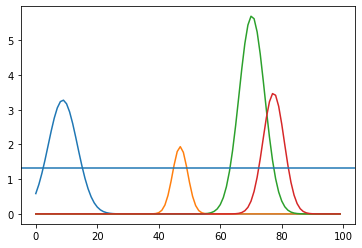

In [18]:
for i in range(4):
    ys=pars_learned_dict['good']['ws'][5,i]*scipy.stats.norm.pdf(np.arange(100),loc=pars_learned_dict['good']['mus'][5,i],scale=pars_learned_dict['good']['sigmas'][5,i])
    plt.plot(ys)
plt.axhline(pars_learned_dict['good']['b'][5])
